# Global Air Quality Index
In this notebook we'll compute the forecasts of the global air quality index (AQI). The computation of the AQI forecast is based on the forecast concentration of some pollutants: $O_3, NO_2, SO_2, PM2.5, PM10$, and is done according to the [European Air Quality Index](https://en.wikipedia.org/wiki/Air_quality_index#Europe) definition. The concentration of the pollutants will be time averaged and transformed in $\mu g \cdot m^{-3}$ and finally classified in one of six levels, from *Very good* to *Extremly poor*, according to the threshold levels defined in the European Air Quality Index. The air quality index is the highest value of the concentration levels of the pollutants. For instance, if the concentration level for all the pollutants but $O_3$ is *Very good* but for $O_3$ is *Medium*, then the air quality index is *Medium*.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcol
from matplotlib.colors import ListedColormap
from zipfile import ZipFile

## The CAMS CDS API
We use the [CAMS global atmospheric composition forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview) dataset. The spatial resolution is lower than that available for the [CAMS European air quality forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) used in previous edition of the training event but it covers the whole planet. The dataset is available from the Copernicus Atmosphere Monitoring Service (CAMS) web service. The spatial grid is 0.4° x 0.4° so that each cell has size 44 km x 44 km, approximately.  In order to compute the air quality index we will download the data of the pollutants and meteorological data: surface pressure, and temperature. The variables are provided for 137 vertical levels, the above surface level is 137. We will use only the data at the surface level.

* Ozone mass mixing ratio [kg kg**-1]
* Sulphur dioxide mass mixing ratio [kg kg**-1]
* Nitrogen dioxide mass mixing ratio [kg kg**-1]
* Particulate matter d <= 2.5 um [kg m**-3]
* Particulate matter d <= 10 um [kg m**-3]

* Surface pressure [Pa]
* Air temperature [K]

The concentration of the trace gases is given using a dimensionless unit. Since we want to use a common unit for all the pollutants we will have to transform the trace gases data from a dimensionless unit to mass concentration. We will use the surface pressure and the air temperature to perform such transformation. We use the forecast data for two days, starting at 00:00

In [2]:
date1 = '2024-08-12'
date2 = '2024-08-12'
init_hour = '00'
lead_time_start = 3
lead_time_stop = 48
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, lead_time_start))
variables = [
            'nitrogen_dioxide', 
            'ozone', 
            'particulate_matter_10um',
            'particulate_matter_2.5um', 
            'sulphur_dioxide', 
            'surface_pressure',
            'temperature',
            ]
bb_north = 90
bb_south = -90
bb_west = -180
bb_east = 180
area = [bb_north, bb_west, bb_south, bb_east]

In [3]:
DATADIR = 'data'
WDIR = f'cams_fc_eaqi_{date1}_{date2}_{init_hour}'
WDIR2 = f'cams_fc_pm_{date1}_{date2}_{init_hour}'

In [4]:
import cdsapi
c = cdsapi.Client()

In [5]:
c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': variables,
		'date': f'{date1}/{date2}',
        'time': f'{init_hour}:00',
        'leadtime_hour': leadtime_hours,
        'model_level': '137',
        'type': 'forecast',
        'area': area,
        'format': 'netcdf_zip',
    },
    f'{DATADIR}/{WDIR}.zip')

2024-08-12 17:00:17,528 INFO Welcome to the CDS
2024-08-12 17:00:17,530 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-08-12 17:00:17,576 INFO Request is queued
2024-08-12 17:00:18,608 INFO Request is running
2024-08-12 17:00:30,920 INFO Request is completed
2024-08-12 17:00:30,920 INFO Downloading https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.mars_constrained.internal-1723474829.1893194-373-6-75cefa4c-e1e4-430b-a545-b0bce7e319a7.zip to data/cams_fc_eaqi_2024-08-12_2024-08-12_00.zip (86.7M)
2024-08-12 17:00:38,810 INFO Download rate 11M/s    


Result(content_length=90936728,content_type=application/zip,location=https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.mars_constrained.internal-1723474829.1893194-373-6-75cefa4c-e1e4-430b-a545-b0bce7e319a7.zip)

We open the zip file and extract the data into a folder. Trace gases concentration and temperature data are in levtype_ml.nc, particulate matter and surface pressure data are in levtype_sfc.nc.

In [6]:
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

In [7]:
#maplon = [-90,-65]
#maplat = [35,50]
#maplon = [-180,180]
#maplat = [-90,90]
#region = 'europe'
#maplon = [-25,40]
#maplat = [30,70]
#region = 'southkorea'
#maplon = [115,145]
#maplat = [30,50]

#proj_in = ccrs.PlateCarree()
#projection = proj_in
#projection = ccrs.TransverseMercator(0)
#projection = ccrs.AlbersEqualArea(central_longitude=0, central_latitude=45)

#lllabs = True

#lonmin = maplon[0]
#lonmax = maplon[1]
#latmin = maplat[0]
#latmax = maplat[1]

In [8]:
dsl = xr.open_dataset(f'{DATADIR}/{WDIR}/levtype_ml.nc')  # trace gases and meteo data
dss = xr.open_dataset(f'{DATADIR}/{WDIR}/levtype_sfc.nc') # aerosols
#ds = xr.merge([dsl, dss])
#ds = ds.where((ds.latitude < latmax) & (ds.latitude > latmin) & (ds.longitude < lonmax) & (ds.longitude > lonmin),drop=True)

## Aerosols
The concentration of aerosol PM2.5 and PM10 are provided as densities in $kg \cdot m^{-3}$ 

In [9]:
dss

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 16)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-12T03:00:00 ... 2024-08-14
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    pm10       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-12 15:00:28 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Trace gases
The concentration of the trace gases is provided as mixing ratio, a dimensionless quantity that represents the ratio between the mass concentration of the trace gas, in kg per unit volume, and the mass concentration of air.  

In [10]:
dsl

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 16)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-12T03:00:00 ... 2024-08-14
Data variables:
    go3        (time, latitude, longitude) float32 ...
    so2        (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    no2        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-12 15:00:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Scaling factor
We calculate the scaling factor, to convert the dimensionless mixing ratios of $NO_2, SO_2$, and $O_3$ from kg/kg to mass density in ug/m3, using the air surface pressure, the temperature. We start from the definition of mass mixing ratio of a chemical species X in air

$$\alpha_x = \frac{\rho_x}{\rho}$$

where $\rho_x$ is the mass density of the chemical species X in $kgm^{-3}$ and $\rho$ is the mass density of the air. We assume the trace gases and the dry air to follow the ideal gas law so that for dry air we can write

$$pV = nRT$$

where p is the air pressure, $R = K_B N_A = 8.314 \text{ } JK^{-1}mol^{-1}$ is the ideal gas constant, where $K_B$ is the Boltzmann constant and $N_A$ is the Avogadro's number, V the volume, T the temperature, and finally n is the number of moles. The number of moles is defined as the ratio of the mass and the molar mass. For dry air, a mixture of several gases, the molar mass $M_a$ can be represented by the weighted sum of the molar masses of all the chemical species in the air (see Jacob, chap.1, p.4)

$$M_a = \sum_i w_iM_i = 28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}$$

With this defnition the number of moles of dry air can be written as

$$n = \frac{m}{M_a}$$
 
where m is the mass of the dry air. Substituting this definition into the gas law for dry air we have

$$pV = \frac{m}{M_a}RT$$

We can define the gas constant of dry air from the ideal gas constant R and the molar mass of dry air

$$R_a = \frac{R}{M_a} = \frac{8.314 \text{ } JK^{-1}mol^{-1}}{28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}} = 287.08 \text{ } JK^{-1}kg^{-1}$$

We can now write the law for dry air as

$$pV = mR_aT$$

and

$$p = \frac{m}{V}R_aT = \rho R_aT$$

so that the mass density of dry air is

$$\rho = \frac{p}{R_aT}$$

from which we can write the equation of the mass density of a chemical species in the air as a function of its mixing ratio, the air pressure and temperature, and given the air specific gas constant

$$\rho_x = \alpha_x \frac{p}{R_aT} \text{ } kg m^{-3}$$

If we define the factor c as

$$c = \frac{p}{R_aT}$$

we can transform the mixing ratio of a chemical species to mass density using the equation

$$\rho_x = c \alpha_x$$

We calculate the scaling factor

In [11]:
R = 287.08
cfactor = dss['sp'] / (R * dsl['t'])

Now we can transform the concentration values of the trace gases into $kg \cdot m^{-3}$. Me multiply for $10^9$ to represent the values in $\mu g \cdot m^{-3}$

In [12]:
params1 = ['no2','go3','so2']
for param in params1:
    dsl[param] = dsl[param] * cfactor * 1e9

In [13]:
params2 = ['pm2p5','pm10']
for param in params2:
    dss[param] = dss[param] * 1e9

In [57]:
variable_name = 'no2'
statistics = five_num_statistics(dsl[variable_name])
print_statistics(variable_name, statistics)

no2 concentration (micrograms/m^3)
Min.: 0.0
Low quartile: 0.0
Median.: 0.0
Up quartile: 0.2
Max: 4188.4
IQR: 0.2
Skew: 1.0



## 24h average
We aggregate the data by computing the mean daily values of the trace gases concentration and maximum daily values of the aerosol matter concentration.

In [14]:
dsl_max = dsl.resample(time='1D').max()
dsl_max = dsl_max.squeeze(drop=True)

In [15]:
dss_mean = dss.resample(time='1D').mean()
dss_mean = dss_mean.squeeze(drop=True)

In [16]:
eaqi_daily = xr.merge([dsl_max,dss_mean])
eaqi_daily

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 3)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-12 2024-08-13 2024-08-14
Data variables:
    go3        (time, latitude, longitude) float32 58.9 58.9 58.9 ... 58.7 58.7
    so2        (time, latitude, longitude) float32 0.03497 0.03497 ... 0.0 0.0
    t          (time, latitude, longitude) float32 274.1 274.1 ... 220.2 220.2
    no2        (time, latitude, longitude) float32 1.879 1.879 1.879 ... 0.0 0.0
    pm2p5      (time, latitude, longitude) float32 5.954 5.954 ... -0.0004547
    sp         (time, latitude, longitude) float32 1.003e+05 ... 6.9e+04
    pm10       (time, latitude, longitude) float32 11.64 11.64 11.64 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-12 15:00:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [17]:
eaqi_daily = eaqi_daily.drop_vars(["t", "sp"])

In [18]:
eaqi_daily

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 3)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-12 2024-08-13 2024-08-14
Data variables:
    go3        (time, latitude, longitude) float32 58.9 58.9 58.9 ... 58.7 58.7
    so2        (time, latitude, longitude) float32 0.03497 0.03497 ... 0.0 0.0
    no2        (time, latitude, longitude) float32 1.879 1.879 1.879 ... 0.0 0.0
    pm2p5      (time, latitude, longitude) float32 5.954 5.954 ... -0.0004547
    pm10       (time, latitude, longitude) float32 11.64 11.64 11.64 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-12 15:00:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Exploratory data analysis and outliers detection
Before visualization we perfom a simple data analysis, mostly to assess whether there are outliers in the dataset, that is values that are far from the bulk of the data. This step is useful in general and in particular when we want to plot the data since outliers have a strong impact on visualization. We calculate for each variable 5 descriptive statistical parameters: min, lower quartile, median, upper quartile, and max. If we observe a large maximum value compared with the upper quartile it is likely that the dataset contains outliers, that is values that are far from the bulk of the data and might not come from real observations.

In [31]:
def five_num_statistics(xr_da):
    """
    This function returns a list of 5 descriptive statistical
    parameters of an xarray DataArray:
    min, lower quartile, median, upper quartile, max.
    """
    da_min = xr_da.min()
    da_lq = xr_da.quantile(.25)
    da_median = xr_da.median()
    da_uq = xr_da.quantile(.75)
    da_max = xr_da.max()
    iqr = da_uq - da_lq
    skew = (da_lq -2 * da_median + da_uq) / iqr
    return [da_min, da_lq, da_median, da_uq, da_max, iqr, skew]

In [58]:
def print_statistics(variable_name, statistics):
        min = statistics[0] 
        lq = statistics[1]
        median = statistics[2]
        uq = statistics[3]
        max= statistics[4]
        iqr = statistics[5]
        skew = statistics[6]
        print(variable_name + ' concentration (micrograms/m^3)\n' \
            'Min.: {:.2f}\n' \
            'Low quartile: {:.2f}\n' \
            'Median.: {:.2f}\n' \
            'Up quartile: {:.2f}\n' \
            'Max: {:.2f}\n' \
            'IQR: {:.2f}\n' \
            'Skew: {:.2f}\n'.format(min, 
                                 lq, 
                                 median,
                                 uq,
                                 max,
                                 iqr,
                                 skew))

In [237]:
def contour_levels(xr_da):
    temp_quantile_list = []
    quantile_list = []
    order = np.linspace(0,1,100)
    for q in order:
        quantile = xr_da.quantile(q).item()
        temp_quantile_list.append(quantile)
    for i in range(0, len(order) - 1):
        if temp_quantile_list[i + 1] > 0 and temp_quantile_list[i + 1] > 1.1 * temp_quantile_list[i]:
            quantile_list.append(temp_quantile_list[i])
    return quantile_list

In [247]:
def shorten_levels(levels, max_levels):
    short_levels = []
    num_levels = len(levels)
    print(num_levels)
    if num_levels > max_levels:
        step = int(num_levels / max_levels)
        print(step)
        for i in range(0, num_levels, step):
            short_levels.append(levels[i])
    return short_levels

In [290]:
from datetime import datetime
timestamp = eaqi_daily['no2'].time
day = str(timestamp.values[0])[:10]
day

'2024-08-12'

In [248]:
variable_name = 'no2'
no2_levels = shorten_levels(contour_levels(eaqi_daily[variable_name]), 10)
no2_levels

32
3


[0.0,
 0.1289899469626072,
 0.3002889180424239,
 0.4279452429877387,
 0.6162610060036785,
 0.8910675392006384,
 1.251548840542033,
 1.787013636695015,
 2.64026797901501,
 4.263491370461205,
 9.126327620612262]

In [249]:
variable_name = 'go3'
o3_levels = contour_levels(eaqi_daily[variable_name])
o3_levels

[0.7757483720779419,
 19.944931319265656,
 23.533708495323104,
 118.83961995442795,
 138.49132483896582]

In [250]:
variable_name = 'so2'
so2_levels = shorten_levels(contour_levels(eaqi_daily[variable_name]), 10)
so2_levels

18
1


[0.0,
 0.03891316304604213,
 0.0689292714902849,
 0.08115636406823865,
 0.10308537699959498,
 0.13973797722296288,
 0.1733097614664021,
 0.8332901398340866,
 0.9250945340503347,
 1.038055495782333,
 1.1803787356675317,
 1.3691407646795728,
 1.6130694042552618,
 1.9496821369787691,
 2.4261255216116924,
 3.168273427269675,
 4.61998056161286,
 8.532777410564993]

In [251]:
variable_name = 'pm2p5'
pm25_levels = shorten_levels(contour_levels(eaqi_daily[variable_name]), 10)
pm25_levels

19
1


[-0.0004547473508864641,
 0.04746425151824951,
 0.1273292452096939,
 0.17541876435279846,
 0.2555679976940155,
 0.38335201144218445,
 0.5475807785987854,
 0.7667040228843689,
 0.9745804071426392,
 1.2417850494384766,
 1.533862829208374,
 1.7898855209350586,
 2.1252617835998535,
 2.4288055896759033,
 2.7006306648254395,
 27.03271484375,
 30.81368064880371,
 40.27515411376953,
 62.723630269368485]

In [252]:
variable_name = 'pm10'
pm10_levels = shorten_levels(contour_levels(eaqi_daily[variable_name]), 10)
pm10_levels

20
2


[0.0,
 0.1823536902666092,
 0.4794174134731293,
 0.9135874509811401,
 1.6443663835525513,
 2.5579538345336914,
 3.563002347946167,
 4.56793737411499,
 57.376831362945865,
 102.32815551757812]

In [253]:
all_levels = [no2_levels, o3_levels, so2_levels, pm25_levels, pm10_levels]

In [219]:
variable_name = 'no2'
statistics = five_num_statistics(eaqi_daily[variable_name])
print_statistics(variable_name, statistics)

no2 concentration (micrograms/m^3)
Min.: 0.00
Low quartile: 0.00
Median.: 0.00
Up quartile: 0.35
Max: 4188.39
IQR: 0.35
Skew: 1.00



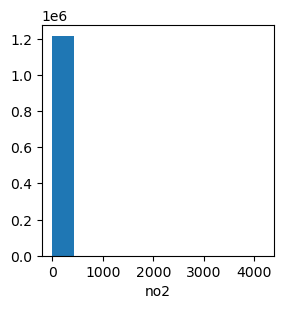

In [34]:
h_plot = eaqi_daily[variable_name].plot.hist(figsize=(3,3))

In [35]:
variable_name = 'go3'
statistics = five_num_statistics(eaqi_daily[variable_name])
print_statistics(variable_name, statistics)

go3 concentration (micrograms/m^3)
Min.: 0.8
Low quartile: 51.3
Median.: 64.1
Up quartile: 72.1
Max: 589.9
IQR: 20.8
Skew: -0.2



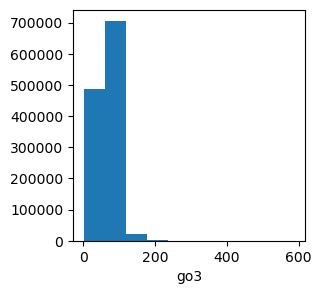

In [36]:
h_plot = eaqi_daily[variable_name].plot.hist(figsize=(3,3))

In [38]:
variable_name = 'so2'
statistics = five_num_statistics(eaqi_daily[variable_name])
print_statistics(variable_name, statistics)

so2 concentration (micrograms/m^3)
Min.: 0.0
Low quartile: 0.0
Median.: 0.1
Up quartile: 0.3
Max: 2043.2
IQR: 0.3
Skew: 0.3



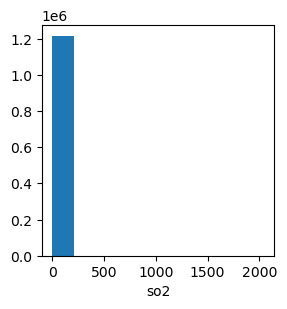

In [39]:
h_plot = eaqi_daily[variable_name].plot.hist(figsize=(3,3))

In [40]:
variable_name = 'pm2p5'
statistics = five_num_statistics(eaqi_daily[variable_name])
print_statistics(variable_name, statistics)

pm2p5 concentration (micrograms/m^3)
Min.: -0.0
Low quartile: 3.5
Median.: 10.1
Up quartile: 16.3
Max: 4288.0
IQR: 12.8
Skew: -0.0



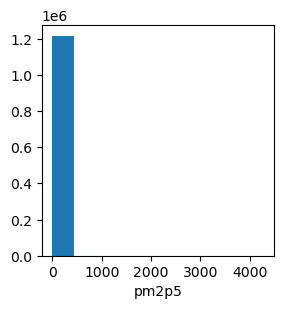

In [41]:
h_plot = eaqi_daily[variable_name].plot.hist(figsize=(3,3))

In [42]:
variable_name = 'pm10'
statistics = five_num_statistics(eaqi_daily[variable_name])
print_statistics(variable_name, statistics)

pm10 concentration (micrograms/m^3)
Min.: 0.0
Low quartile: 5.9
Median.: 18.9
Up quartile: 31.7
Max: 6129.4
IQR: 25.9
Skew: -0.0



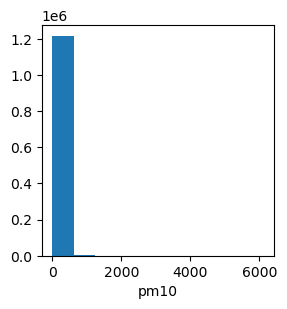

In [43]:
h_plot = eaqi_daily[variable_name].plot.hist(figsize=(3,3))

In [44]:
eaqi_daily_clean_list = []
params = ['no2','go3','so2','pm2p5','pm10']
for i,param in enumerate(params):
    lq = eaqi_daily[param].quantile(.25)
    uq = eaqi_daily[param].quantile(.75)
    q99 = eaqi_daily[param].quantile(.99)
    iqr = uq - lq
    critical_value = uq + 1.5 * iqr
    eaqi_daily_clean = eaqi_daily[param].where(eaqi_daily[param] < q99, other=lq)
    eaqi_daily_clean_list.append(eaqi_daily_clean)

eaqi_daily_clean_xr = xr.merge(eaqi_daily_clean_list)

no2 concentration (micrograms/m^3)
Min.: 0.00
Low quartile: 0.00
Median.: 0.00
Up quartile: 0.31
Max: 15.19
IQR: 0.31
Skew: 1.00

go3 concentration (micrograms/m^3)
Min.: 0.78
Low quartile: 51.29
Median.: 63.71
Up quartile: 71.80
Max: 138.81
IQR: 20.51
Skew: -0.21

so2 concentration (micrograms/m^3)
Min.: 0.00
Low quartile: 0.03
Median.: 0.13
Up quartile: 0.31
Max: 8.61
IQR: 0.28
Skew: 0.31

pm2p5 concentration (micrograms/m^3)
Min.: -0.00
Low quartile: 3.47
Median.: 9.84
Up quartile: 16.02
Max: 63.08
IQR: 12.55
Skew: -0.02

pm10 concentration (micrograms/m^3)
Min.: 0.00
Low quartile: 5.87
Median.: 18.35
Up quartile: 31.14
Max: 177.95
IQR: 25.27
Skew: 0.01



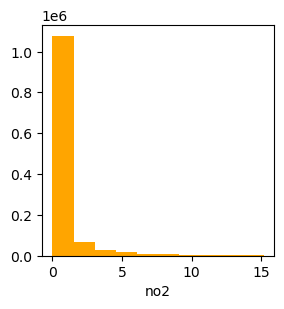

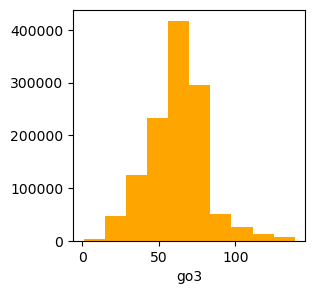

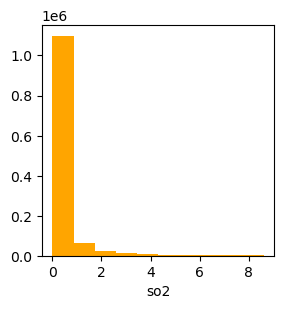

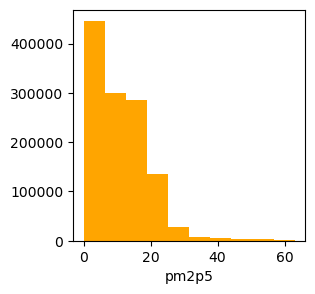

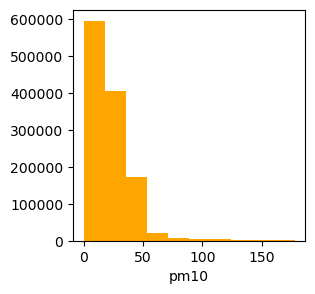

In [230]:
for i, param in enumerate(params):
    clean_plot = eaqi_daily_clean_xr[param].plot.hist(figsize=(3,3), color='orange')
    clean_plot
    statistics = five_num_statistics(eaqi_daily_clean_xr[param])
    print_statistics(param, statistics)

## Plot the global concentrations of the trace gases and aerosol matter
From the shape of the dataset (height and width) and the spatial resolution we should be able to calculate the global area that should be equal top the Earth surface. 

In [46]:
params = ['no2','go3','so2','pm2p5','pm10']
clevs_p = [
    [0, 40, 100, 200, 400, 1000],
    [0, 80, 120, 180, 240, 600],
    [0, 100, 200, 350, 500, 1250],
    [0, 10, 20, 25, 50, 800],
    [0, 20, 35, 50, 100, 1200]
]

We define a colormap for the AQI

In [47]:
eaqi_daily_no2_index = np.digitize(eaqi_daily['no2'][2,:,:], clevs_p[0])
eaqi_daily_no2_index

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

In [144]:
def digitize_xr(data, day_index, params, levels):
    """
    This function computes the bin number of each value in the data
    according to the levels defined for each parameter. The binning
    is computed using the NumPy function digitize(). The apply_ufun()
    function is used to return an xarray dataset instead of a NumPy 
    array.
    """
    classified_arrays = []
    for i in range(0,len(data)):
        variable = params[i]
        temp = xr.apply_ufunc(np.digitize, data[variable], levels[i])
        classified_arrays.append(temp)
    return classified_arrays

In [159]:
classified_arrays = digitize_xr(eaqi_daily, 2, params, clevs_p)
classified_arrays[0].shape

(3, 451, 900)

In [300]:
green_color = '#5AAA5F'
light_green_color = '#A7D25C'
yellow_color = '#ECD347'
dark_yellow_color = '#F5BE41'
orange_color = '#F09235'
red_color = '#D93322'
colors = [green_color, light_green_color, yellow_color, dark_yellow_color, orange_color, red_color]
aqi_cmap = ListedColormap(colors)

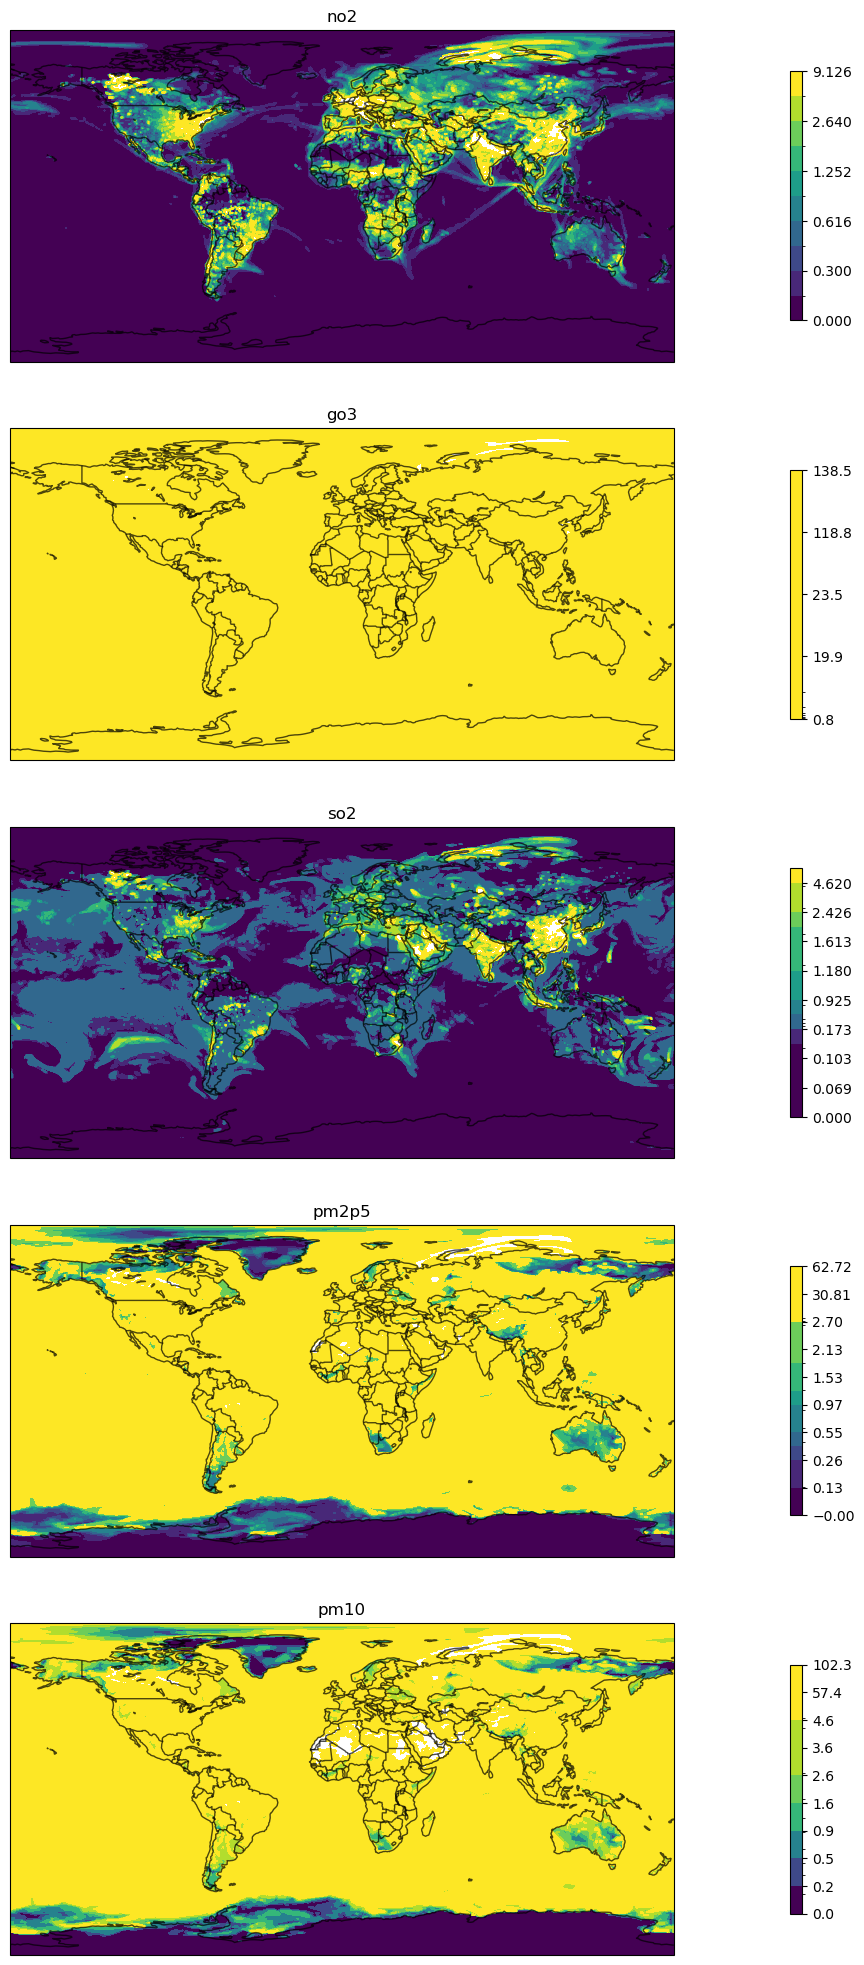

In [254]:
from matplotlib import cm, ticker
#nrows=2
#ncols=3
fig, axs = plt.subplots(nrows=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(30, 25))

for i,param in enumerate(params):
    # Specify geographical extent
    
    #da = eaqi_daily_clean_xr[param]
    da = eaqi_daily[param]
    clevs = no2_levels
    day_index = 2
    data = da[day_index,:,:]
    vmin = int(data.min())
    vmax = int(data.quantile(0.9))
    cs = axs[i].contourf(da.longitude, da.latitude, da[day_index,:,:], 
                        levels = all_levels[i], 
                       # vmin=vmin, 
                       # vmax=vmax,
                       # cmap='viridis', 
                        norm = mcol.BoundaryNorm(no2_levels, 256), 
                       # robust=True,
                         transform=ccrs.PlateCarree())

    cbar = plt.colorbar(cs, fraction=0.046, pad=0.05, orientation='vertical', shrink=0.75)
    axs[i].set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree()) 
    axs[i].set_title(param)
    axs[i].coastlines(color='black', alpha=0.7) 
    axs[i].add_feature(cfeature.LAKES, alpha=0.7, edgecolor='black', facecolor='none')
    axs[i].add_feature(cfeature.BORDERS, alpha=0.7)
    axs[i].margins(1.0)

## Calculating the air quality index
An algorithm to calculate the AQI is described in p.18 of the [Technical Assistance Document for the Reporting of Daily Air Quality](https://www.airnow.gov/publications/air-quality-index/technical-assistance-document-for-reporting-the-daily-aqi/)  
**Add example calculation for O3 using the concentration and the thresholds**  
The air quality index of the chemical species X is calculated using the equation

$$I_x = \frac{I_{high} - I_{low}}{C_{high} - C_{low}}(C_x - C_{low}) + I_{low}$$

then the index is rounded to the nearest integer.


|$NO_2$ $(\mu g/m^3)$|$O_3$ $(\mu g/m^3)$|$SO_2$ $(\mu g/m^3)$|$PM2.5$ $(\mu g/m^3)$|$PM10$ $(\mu g/m^3)$| AQI|Category|
|---------|--------|------|-----------|------------|--------|-------|
| 0-40 | 0-50 | 0-100| 0-10 | 0-20|1|Very Good|
| 40-90 | 50-100 | 100-200 | 10-20 | 20-40 | 2|Good|
| 90-120 | 100-130 | 200-350 | 20-25 | 40-50 | 3|Medium|
| 120-230 | 130-240 | 350-500 | 25-50 | 50-100 | 4|Poor|
| 230-340 | 240-380 | 500-750 | 50-75 | 100-150 | 5|Very Poor|
| 340-1000 | 380-800 | 750-1250 | 75-800 | 150-1200 | 6|Extremely Poor|

In [292]:
cmap = ListedColormap(['#5AAA5F', '#A7D25C', '#ECD347', '#F5BE41', '#F09235'])    #, '#D93322'])
labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor']                     #, 'Extremely Poor']
#levels1 = [0.5,1.5,2.5,3.5,4.5,5.5]                                               #,6.5]
#levels2 = [1,2,3,4,5]                                                             #,6]

We define the concentration levels for each pollutant in $\mu g m^{-3}$

In [293]:
#clevs = []
#for i,param in enumerate(params):
#    da = eaqi_daily[param] 
#    vmin = da.min()
#    vmax_ = da.max() / 5
#    vdiv = (vmax_ - vmin) / 10
#    vmax = vmax_ + vdiv
#    #clevs = np.arange(vmin,vmax,vdiv)
#    clevs = clevs_p[i]

## AQI calculation

In [294]:
#no2_limits = [0, 40, 90, 120, 230, 340, 1000]
#ozone_limits = [0, 50, 100, 130, 240, 380, 800]
#pm10_limits = [0, 10, 20, 25, 50, 75, 800]
#pm25_limits = [0, 20, 40, 50, 100, 150, 1200]
#so2_limits = [0, 100, 200, 350, 500, 750, 1250]
no2_limits = [0,40,100,200,400,1000]
ozone_limits = [0,80,120,180,240,600]
pm10_limits = [0,20,35,50,100,1200]
pm25_limits = [0,10,20,25,50,800]
so2_limits = [0,100,200,350,500,1250]

bin_list = [no2_limits, ozone_limits, pm10_limits, pm25_limits, so2_limits]
variable_list = ['no2', 'go3','pm10', 'pm2p5', 'so2'] #list(eaqi_daily.variables)

In [295]:
classified_arrays = []
for i in range(0,len(bin_list)):
    variable = variable_list[i]
    temp = xr.apply_ufunc(np.digitize,
              eaqi_daily[variable],
              bin_list[i])
    classified_arrays.append(temp)

In [296]:
combined = xr.merge(classified_arrays)

In [297]:
combined.values()

ValuesView(<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 3)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-12 2024-08-13 2024-08-14
Data variables:
    no2        (time, latitude, longitude) int64 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    go3        (time, latitude, longitude) int64 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    pm10       (time, latitude, longitude) int64 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    pm2p5      (time, latitude, longitude) int64 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0
    so2        (time, latitude, longitude) int64 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1)

In [298]:
final_index = combined.to_array().max('variable')
final_index.shape

(3, 451, 900)

In [304]:
timestamp = final_index.time
day = str(timestamp.values[0])[:10]
day

'2024-08-12'

In [302]:
cmap = ListedColormap(colors)
labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor']
levels = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
level_ticks = [1, 2, 3, 4, 5, 6]

## Global AQI map
**set the day slice and add it to the title**

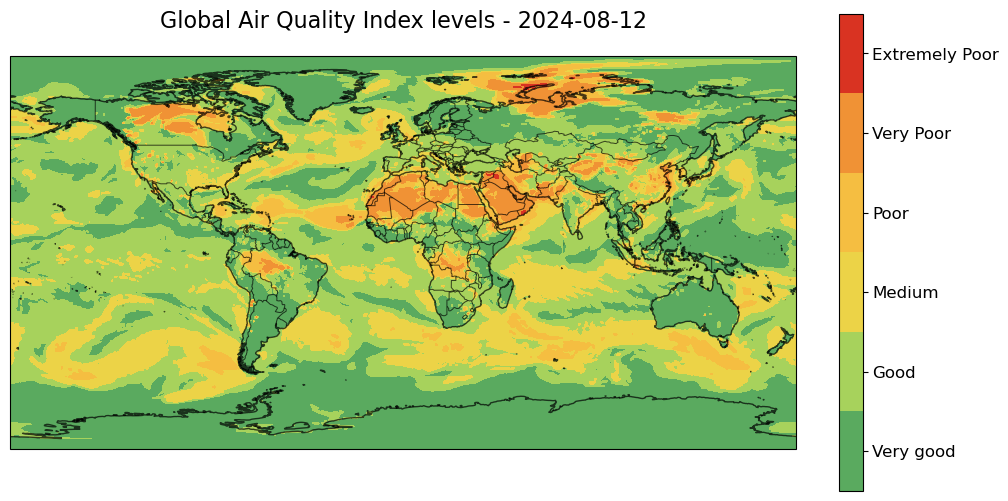

In [306]:
#n = final_index.time.shape[0]-1
n = 1

for i in range(n):
    fig, ax = plt.subplots(1, 1, figsize = (11,8), subplot_kw={'projection': ccrs.PlateCarree()})
    # Specify geographical extent

    # Set figure title
#    dstr1 = (datetime.strptime(dstr0, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
#    dstr = ' valid for '.join([dstr00,dstr1])
#    ax.set_title('CAMS Regional European Air Quality Index forecast: \n '+dstr, fontsize=12)
    # Plotting function
    img = plt.contourf(final_index.longitude, final_index.latitude, 
                       final_index[i,:,:],
                       levels=levels, vmin=1, vmax=6, cmap=ListedColormap(colors))
    
    # Set the title of the plot
    ax.set_title('Global Air Quality Index levels - ' + day, fontsize=16, pad=20.0)
    
    # Customize colorbar
    cbar = plt.colorbar(img, fraction=0.028, pad=0.05) 
    cbar.set_label(None)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks(level_ticks)
    cbar.set_ticklabels(labels)
    
    # Add additional features such as coastlines and a geographic grid 
    ax.coastlines(color='black', alpha=0.7, resolution='50m')
    ax.add_feature(cfeature.BORDERS, alpha=0.7, linewidth=0.7)

## References
* [Jacob - Introduction to Atmospheric Chemistry](https://acmg.seas.harvard.edu/education/introduction-atmospheric-chemistry)
* Wilks - Statistical Methods in Atmospheric Science, 2nd Edition